In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from functools import reduce
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM


In [3]:
# Step 1: Read CSV files
hpcl = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\new\Data\Raw\indian_oil_companies_data\HPCL_OHLC.csv', parse_dates=['Date'])
bpcl = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\new\Data\Raw\indian_oil_companies_data\BPCL_OHLC.csv', parse_dates=['Date'])
gail = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\new\Data\Raw\indian_oil_companies_data\GAIL_OHLC.csv', parse_dates=['Date'])
iocl = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\new\Data\Raw\indian_oil_companies_data\IOCL_OHLC.csv', parse_dates=['Date'])
crude = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\new\Data\Indian_Crude_Basket_OHLC.csv', parse_dates=['Date'])


In [6]:
# Ensure all Date columns are timezone-naive (remove tz info)
for df in [hpcl, bpcl, gail, iocl, crude]:
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

# Prefix columns to avoid clashes
def prefix_columns(df, prefix):
    df = df.copy()
    df.columns = ['Date'] + [f"{prefix}_{col}" if col != 'Date' else col for col in df.columns[1:]]
    return df

hpcl = prefix_columns(hpcl, 'HPCL')
bpcl = prefix_columns(bpcl, 'BPCL')
gail = prefix_columns(gail, 'GAIL')
iocl = prefix_columns(iocl, 'IOCL')
crude = prefix_columns(crude, 'CRUDE')

# Merge all dataframes on Date
from functools import reduce
dfs = [hpcl, bpcl, gail, iocl, crude]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)

# Sort by Date
merged_df.sort_values('Date', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

print(merged_df.head())


        Date  HPCL_Open  HPCL_High  HPCL_Low  HPCL_Close  HPCL_Volume  \
0 1996-01-02   8.889839   8.889839  8.799435    8.799435       5062.0   
1 1996-01-03   8.739168   8.739168  8.739168    8.739168       1012.0   
2 1996-01-04   8.739168   8.739168  8.739168    8.739168          0.0   
3 1996-01-05   8.588489   8.799435  8.498084    8.799435     963900.0   
4 1996-01-08   8.799436   8.498085  8.469457    8.469457       2025.0   

   HPCL_Dividends  HPCL_Stock Splits  BPCL_Open  BPCL_High  ...  IOCL_High  \
0             0.0                0.0   3.366443   3.338153  ...        NaN   
1             0.0                0.0   3.306328   3.306328  ...        NaN   
2             0.0                0.0   3.306328   3.324009  ...        NaN   
3             0.0                0.0   3.324009   3.324009  ...        NaN   
4             0.0                0.0   3.324010   3.288649  ...        NaN   

   IOCL_Low  IOCL_Close  IOCL_Volume  IOCL_Dividends  IOCL_Stock Splits  \
0       NaN      

In [84]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7488 entries, 0 to 7487
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               7488 non-null   datetime64[ns]
 1   HPCL_Open          7463 non-null   float64       
 2   HPCL_High          7463 non-null   float64       
 3   HPCL_Low           7463 non-null   float64       
 4   HPCL_Close         7463 non-null   float64       
 5   HPCL_Volume        7463 non-null   float64       
 6   HPCL_Dividends     7463 non-null   float64       
 7   HPCL_Stock Splits  7463 non-null   float64       
 8   BPCL_Open          7463 non-null   float64       
 9   BPCL_High          7463 non-null   float64       
 10  BPCL_Low           7463 non-null   float64       
 11  BPCL_Close         7463 non-null   float64       
 12  BPCL_Volume        7463 non-null   float64       
 13  BPCL_Dividends     7463 non-null   float64       
 14  BPCL_Sto

In [85]:
# 1. Get Crude Oil start and end dates
crude_start = merged_df['CRUDE_Close'].first_valid_index()
crude_end = merged_df['CRUDE_Close'].last_valid_index()

# Convert those index positions to actual dates
crude_min_date = merged_df.loc[crude_start, 'Date']
crude_max_date = merged_df.loc[crude_end, 'Date']

print(f"Aligning all data from {crude_min_date.date()} to {crude_max_date.date()}")


Aligning all data from 2016-01-04 to 2024-12-12


In [86]:
merged_df = merged_df[
    (merged_df['Date'] >= crude_min_date) &
    (merged_df['Date'] <= crude_max_date)
].copy()


In [87]:
merged_df = merged_df.ffill().bfill()


In [88]:
print(merged_df[['Date', 'CRUDE_Close']].head())
print(merged_df[['Date', 'CRUDE_Close']].tail())
print(merged_df.info())


           Date  CRUDE_Close
5060 2016-01-04      33.9900
5061 2016-01-05      33.9900
5062 2016-01-06      34.1700
5063 2016-01-07      34.2100
5064 2016-01-08      32.4825
           Date  CRUDE_Close
7288 2024-12-06    74.020000
7289 2024-12-09    71.962500
7290 2024-12-10    71.962500
7291 2024-12-11    72.572500
7292 2024-12-12    72.945001
<class 'pandas.core.frame.DataFrame'>
Index: 2233 entries, 5060 to 7292
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2233 non-null   datetime64[ns]
 1   HPCL_Open          2233 non-null   float64       
 2   HPCL_High          2233 non-null   float64       
 3   HPCL_Low           2233 non-null   float64       
 4   HPCL_Close         2233 non-null   float64       
 5   HPCL_Volume        2233 non-null   float64       
 6   HPCL_Dividends     2233 non-null   float64       
 7   HPCL_Stock Splits  2233 non-null   float64     

In [89]:
# List of stock prefixes
assets = ['HPCL', 'BPCL', 'GAIL', 'IOCL', 'CRUDE']

for asset in assets:
    close_col = f"{asset}_Close"  # Column name for Close prices
    logret_col = f"{asset}_LogReturn"
    
    # Calculate log return
    merged_df[logret_col] = np.log(merged_df[close_col] / merged_df[close_col].shift(1))

In [90]:
# ATR window
atr_window = 14

for asset in assets:
    high_col = f"{asset}_High"
    low_col = f"{asset}_Low"
    close_col = f"{asset}_Close"
    atr_col = f"{asset}_ATR"
    
    # Previous close
    prev_close = merged_df[close_col].shift(1)
    
    # True Range
    tr = pd.concat([
        merged_df[high_col] - merged_df[low_col],
        (merged_df[high_col] - prev_close).abs(),
        (merged_df[low_col] - prev_close).abs()
    ], axis=1).max(axis=1)
    
    # ATR as rolling mean of TR
    merged_df[atr_col] = tr.rolling(atr_window).mean()


In [91]:
# -------------------------------
# 1. DESCRIPTIVE STATISTICS
# -------------------------------
log_return_cols = [f"{asset}_LogReturn" for asset in assets]
desc_stats = pd.DataFrame({
    'Mean': merged_df[log_return_cols].mean(),
    'Median': merged_df[log_return_cols].median(),
    'StdDev': merged_df[log_return_cols].std(),
    'Skewness': merged_df[log_return_cols].skew(),
    'Kurtosis': merged_df[log_return_cols].kurtosis()
})

print("\n=== Descriptive Statistics for Log Returns ===")
print(desc_stats)


=== Descriptive Statistics for Log Returns ===
                     Mean    Median    StdDev  Skewness   Kurtosis
HPCL_LogReturn   0.000722  0.000589  0.024857 -0.654391   9.931023
BPCL_LogReturn   0.000521  0.000146  0.021662 -0.724766  10.438816
GAIL_LogReturn   0.000640  0.000505  0.020784 -0.291521   7.336565
IOCL_LogReturn   0.000576  0.000426  0.019331 -0.547086   5.723312
CRUDE_LogReturn  0.000342  0.000000  0.025989  0.715899  40.417726


In [92]:
# -------------------------------
# 2. STATIONARITY TEST (ADF)
# -------------------------------
adf_results = []
for col in log_return_cols:
    series = merged_df[col].dropna()
    adf_stat, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series)
    adf_results.append({
        'Asset': col.replace('_LogReturn', ''),
        'ADF Statistic': adf_stat,
        'p-value': pvalue,
        'Used Lag': usedlag,
        'Observations': nobs,
        'Stationary (5%)': 'Yes' if pvalue < 0.05 else 'No'
    })

adf_df = pd.DataFrame(adf_results)
print("\n=== Augmented Dickey-Fuller Test Results ===")
print(adf_df)


=== Augmented Dickey-Fuller Test Results ===
   Asset  ADF Statistic       p-value  Used Lag  Observations Stationary (5%)
0   HPCL     -13.458684  3.565244e-25        12          2219             Yes
1   BPCL     -11.086707  4.179312e-20        17          2214             Yes
2   GAIL     -20.966470  0.000000e+00         5          2226             Yes
3   IOCL     -47.797845  0.000000e+00         0          2231             Yes
4  CRUDE      -7.798751  7.592576e-12        22          2209             Yes


In [93]:
# -------------------------------
# 3. CORRELATION ANALYSIS
# -------------------------------

# 3a. Price Return Correlation
returns_corr = merged_df[log_return_cols].corr()
print("\n=== Pearson Correlation (Log Returns) ===")
display(returns_corr)


=== Pearson Correlation (Log Returns) ===


,HPCL_LogReturn,BPCL_LogReturn,GAIL_LogReturn,IOCL_LogReturn,CRUDE_LogReturn
HPCL_LogReturn,1.000000,0.772549,0.410196,0.730566,-0.036739
BPCL_LogReturn,0.772549,1.000000,0.441952,0.718778,-0.030351
GAIL_LogReturn,0.410196,0.441952,1.000000,0.476562,0.030399
IOCL_LogReturn,0.730566,0.718778,0.476562,1.000000,0.002611
CRUDE_LogReturn,-0.036739,-0.030351,0.030399,0.002611,1.000000


In [94]:
# 3b. Volatility (ATR) Correlation
atr_cols = [f"{asset}_ATR" for asset in assets]
atr_corr = merged_df[atr_cols].corr()
print("\n=== Pearson Correlation (ATR) ===")
print(atr_corr)


=== Pearson Correlation (ATR) ===
           HPCL_ATR  BPCL_ATR  GAIL_ATR  IOCL_ATR  CRUDE_ATR
HPCL_ATR   1.000000  0.843925  0.862341  0.921884  -0.058668
BPCL_ATR   0.843925  1.000000  0.759780  0.784890  -0.054319
GAIL_ATR   0.862341  0.759780  1.000000  0.813318   0.023031
IOCL_ATR   0.921884  0.784890  0.813318  1.000000  -0.084710
CRUDE_ATR -0.058668 -0.054319  0.023031 -0.084710   1.000000


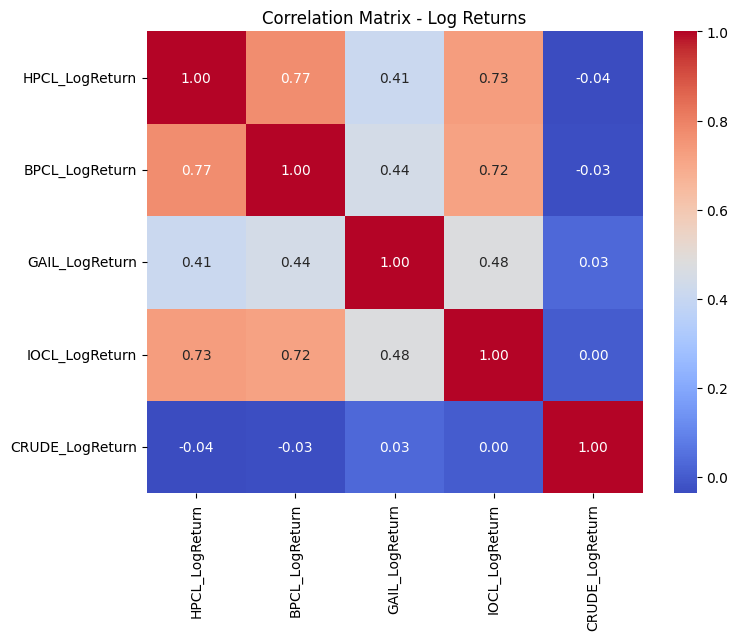

In [95]:
# Optional heatmaps for visualization
plt.figure(figsize=(8,6))
sns.heatmap(returns_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Log Returns")
plt.show()

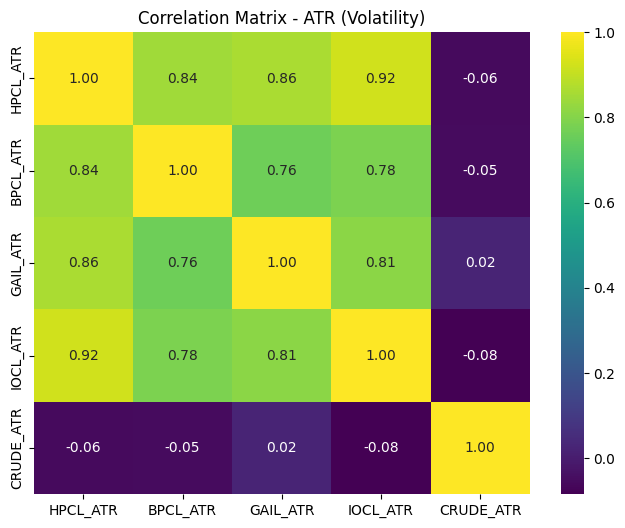

In [96]:
plt.figure(figsize=(8,6))
sns.heatmap(atr_corr, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix - ATR (Volatility)")
plt.show()

In [97]:
# -------------------------------
# 4. GRANGER CAUSALITY TEST
# -------------------------------
granger_results = []
max_lag = 5  # you can increase if needed

for asset in assets:
    if asset == 'CRUDE':
        continue
    test_data = merged_df[['CRUDE_LogReturn', f'{asset}_LogReturn']].dropna()
    # Test if Crude causes Stock
    try:
        result = grangercausalitytests(test_data[['CRUDE_LogReturn', f'{asset}_LogReturn']], maxlag=max_lag, verbose=False)
        min_pvalue = min([round(result[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lag)])
        granger_results.append({
            'Asset': asset,
            'Crude ➜ Stock (p-value)': min_pvalue,
            'Causality (5%)': 'Yes' if min_pvalue < 0.05 else 'No'
        })
    except:
        granger_results.append({'Asset': asset, 'Crude ➜ Stock (p-value)': np.nan, 'Causality (5%)': 'Error'})

granger_df = pd.DataFrame(granger_results)
print("\n=== Granger Causality: Does Crude Predict Stock Returns? ===")
print(granger_df)


=== Granger Causality: Does Crude Predict Stock Returns? ===
  Asset  Crude ➜ Stock (p-value) Causality (5%)
0  HPCL                   0.4924             No
1  BPCL                   0.0158            Yes
2  GAIL                   0.0957             No
3  IOCL                   0.2333             No


c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [98]:
# -------------------------------
# 5. BETA (Systematic Risk)
# -------------------------------
beta_results = []

for asset in assets:
    if asset == 'CRUDE':
        continue
    stock_ret = merged_df[f'{asset}_LogReturn']
    crude_ret = merged_df['CRUDE_LogReturn']
    data = pd.concat([stock_ret, crude_ret], axis=1).dropna()

    X = sm.add_constant(data['CRUDE_LogReturn'])
    y = data[f'{asset}_LogReturn']
    model = sm.OLS(y, X).fit()

    beta = model.params['CRUDE_LogReturn']
    alpha = model.params['const']
    r2 = model.rsquared

    beta_results.append({
        'Asset': asset,
        'Alpha': alpha,
        'Beta': beta,
        'R-squared': r2
    })

beta_df = pd.DataFrame(beta_results)
print("\n=== Beta (Systematic Risk) Relative to Crude Returns ===")
print(beta_df)


=== Beta (Systematic Risk) Relative to Crude Returns ===
  Asset     Alpha      Beta  R-squared
0  HPCL  0.000734 -0.035138   0.001350
1  BPCL  0.000530 -0.025298   0.000921
2  GAIL  0.000632  0.024310   0.000924
3  IOCL  0.000575  0.001942   0.000007


C:\Users\Stevi\AppData\Local\Temp\ipykernel_5984\3130329271.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Asset', y='Beta', data=beta_df, palette='coolwarm')


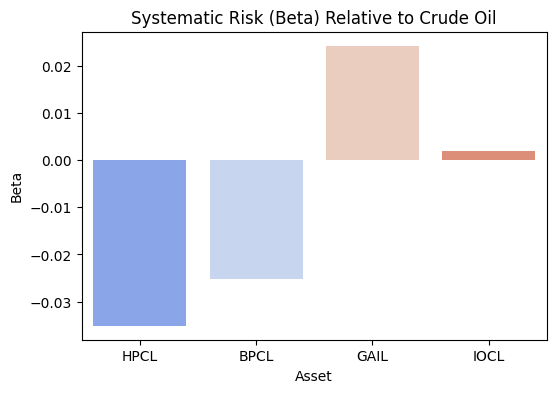

In [99]:
# Optional visualization of Betas
plt.figure(figsize=(6,4))
sns.barplot(x='Asset', y='Beta', data=beta_df, palette='coolwarm')
plt.title('Systematic Risk (Beta) Relative to Crude Oil')
plt.show()

In [100]:
window = 90  # rolling window in days (approx. quarterly)
rolling_betas = pd.DataFrame({'Date': merged_df['Date']})

for asset in assets:
    if asset == 'CRUDE':
        continue

    # Define rolling beta as covariance / variance
    rolling_cov = merged_df[f'{asset}_LogReturn'].rolling(window).cov(merged_df['CRUDE_LogReturn'])
    rolling_var = merged_df['CRUDE_LogReturn'].rolling(window).var()
    rolling_betas[f'{asset}_RollingBeta'] = rolling_cov / rolling_var

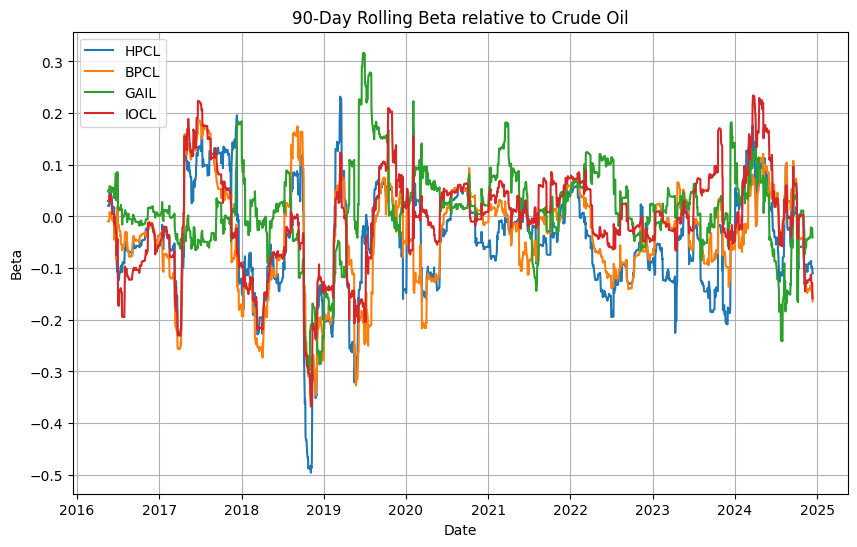

In [101]:
# Plot Rolling Betas
plt.figure(figsize=(10, 6))
for asset in assets:
    if asset == 'CRUDE':
        continue
    plt.plot(rolling_betas['Date'], rolling_betas[f'{asset}_RollingBeta'], label=asset)

plt.title(f'{window}-Day Rolling Beta relative to Crude Oil')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.grid(True)
plt.show()

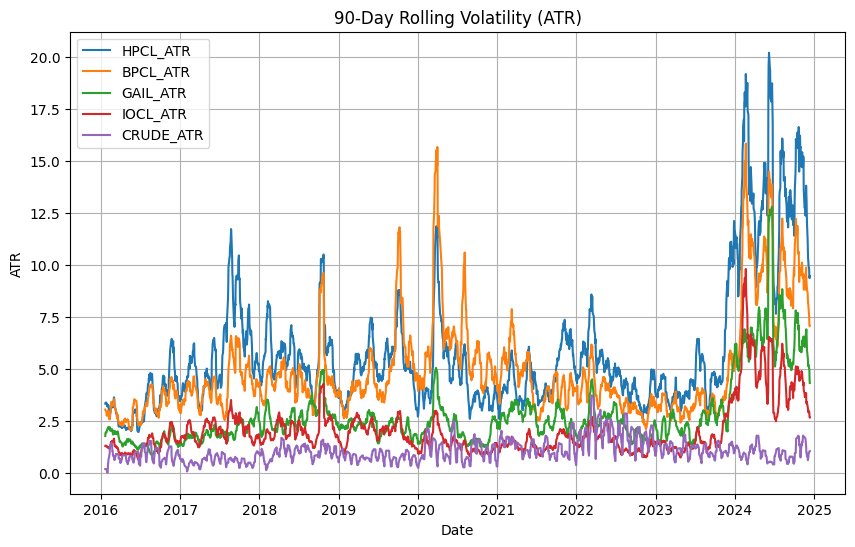

In [102]:
# -------------------------------
# Rolling Volatility (ATR)
# -------------------------------
plt.figure(figsize=(10, 6))
for asset in assets:
    plt.plot(merged_df['Date'], merged_df[f'{asset}_ATR'], label=f'{asset}_ATR')

plt.title(f'{window}-Day Rolling Volatility (ATR)')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
# Prepare data for VAR model
var_data = merged_df[[f'{asset}_LogReturn' for asset in assets]].dropna()

# Check stationarity visually (ADF already confirmed)
print("Shape of VAR data:", var_data.shape)

Shape of VAR data: (2232, 5)


In [104]:
# Fit VAR model
model = VAR(var_data)
selected_lag = model.select_order(maxlags=10)
print("\nLag Order Selection:")
print(selected_lag.summary())


Lag Order Selection:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -40.09     -40.08*   3.874e-18     -40.09*
1      -40.09*      -40.02  3.868e-18*      -40.07
2       -40.09      -39.95   3.873e-18      -40.04
3       -40.09      -39.89   3.872e-18      -40.02
4       -40.09      -39.82   3.884e-18      -39.99
5       -40.09      -39.75   3.901e-18      -39.96
6       -40.09      -39.69   3.889e-18      -39.94
7       -40.08      -39.61   3.938e-18      -39.91
8       -40.07      -39.54   3.968e-18      -39.88
9       -40.06      -39.47   4.015e-18      -39.84
10      -40.05      -39.39   4.061e-18      -39.81
--------------------------------------------------


c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [105]:
# Fit using optimal lag
optimal_lag = selected_lag.aic
results = model.fit(optimal_lag)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Oct, 2025
Time:                     16:54:11
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -40.0143
Nobs:                     2231.00    HQIC:                  -40.0631
Log likelihood:           28923.4    FPE:                3.87843e-18
AIC:                     -40.0911    Det(Omega_mle):     3.82669e-18
--------------------------------------------------------------------
Results for equation HPCL_LogReturn
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.000727         0.000527            1.379           0.168
L1.HPCL_LogReturn         -0.051820         0.036409           -1.423           0.155
L1.BPCL_LogReturn          0.00

In [106]:
# Prepare data
var_data = merged_df[[f'{asset}_LogReturn' for asset in assets]].dropna()

# Fit VAR model (use optimal lag from earlier selection)
model = VAR(var_data)
results = model.fit(maxlags=5, ic='aic')

# Forecast 10 years ahead (~252 trading days per year)
forecast_steps = 252 * 10
forecast_values = results.forecast(var_data.values[-results.k_ar:], steps=forecast_steps)

# Convert to DataFrame
forecast_index = pd.date_range(start=merged_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_df = pd.DataFrame(forecast_values, columns=var_data.columns, index=forecast_index)

print("\n=== 10-Year Forecast: Log Returns ===")
print(forecast_df.head())


=== 10-Year Forecast: Log Returns ===
            HPCL_LogReturn  BPCL_LogReturn  GAIL_LogReturn  IOCL_LogReturn  \
2024-12-13       -0.000195       -0.000296        0.000791        0.000639   
2024-12-16        0.000774        0.000586        0.000618        0.000595   
2024-12-17        0.000720        0.000512        0.000629        0.000558   
2024-12-18        0.000721        0.000515        0.000624        0.000559   
2024-12-19        0.000721        0.000515        0.000624        0.000559   

            CRUDE_LogReturn  
2024-12-13        -0.001033  
2024-12-16         0.000466  
2024-12-17         0.000333  
2024-12-18         0.000341  
2024-12-19         0.000341  


c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


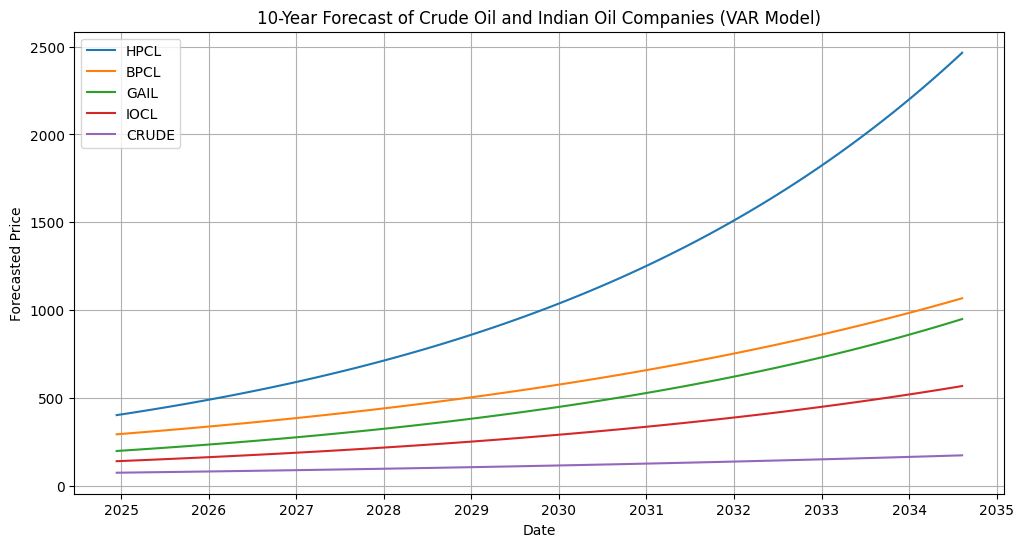

In [107]:
# Convert log returns → cumulative prices (assuming last observed close as base)
price_forecast = pd.DataFrame(index=forecast_index)
for asset in assets:
    base_price = merged_df[f'{asset}_Close'].iloc[-1]
    price_forecast[f'{asset}_ForecastPrice'] = base_price * np.exp(forecast_df[f'{asset}_LogReturn'].cumsum())

# Plot
plt.figure(figsize=(12,6))
for asset in assets:
    plt.plot(price_forecast.index, price_forecast[f'{asset}_ForecastPrice'], label=asset)
plt.title('10-Year Forecast of Crude Oil and Indian Oil Companies (VAR Model)')
plt.xlabel('Date')
plt.ylabel('Forecasted Price')
plt.legend()
plt.grid(True)
plt.show()

\n--- Generating Time Series Plot of Log Returns ---


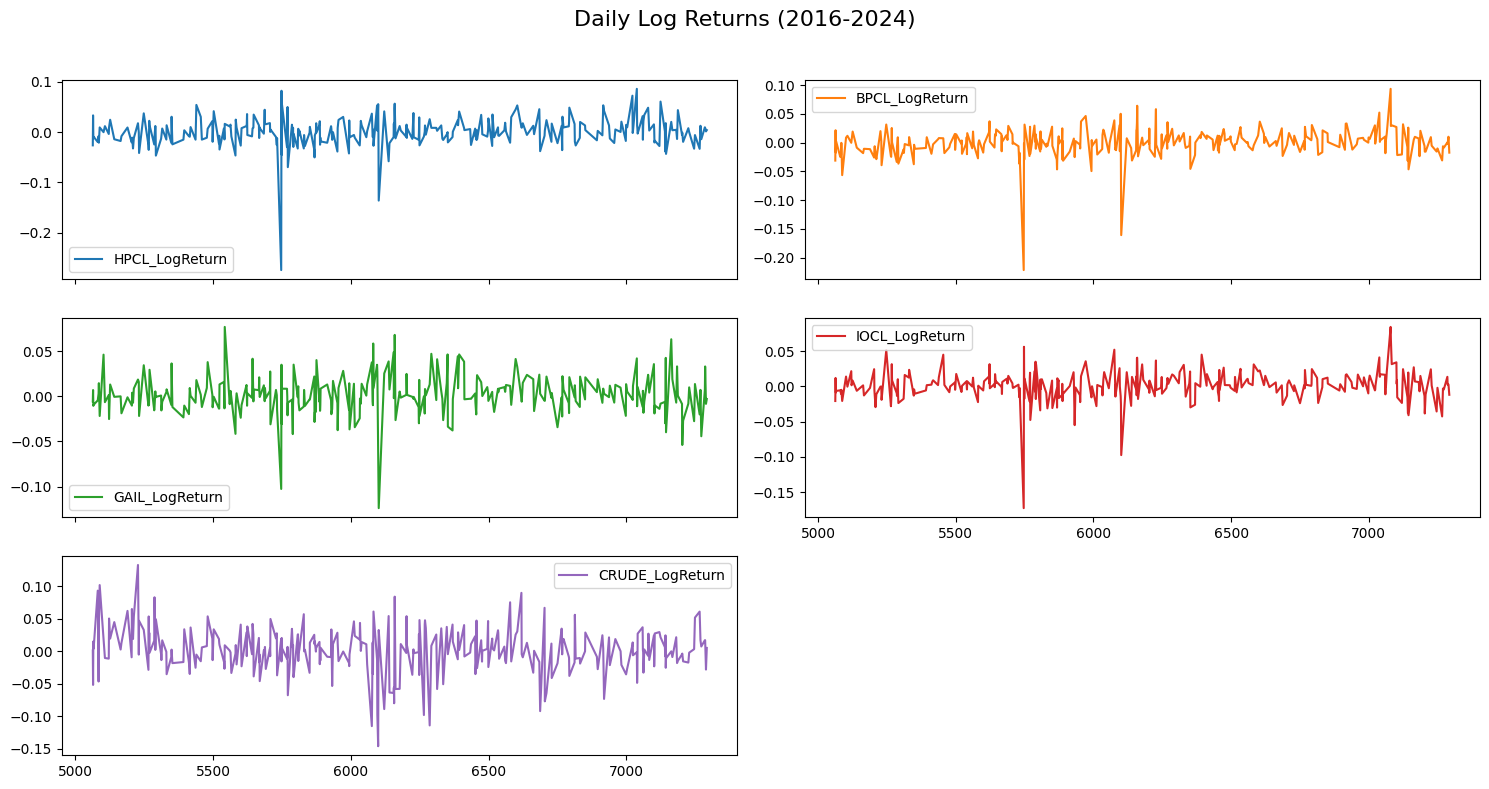

\n--- Calculating Impulse Response Functions ---


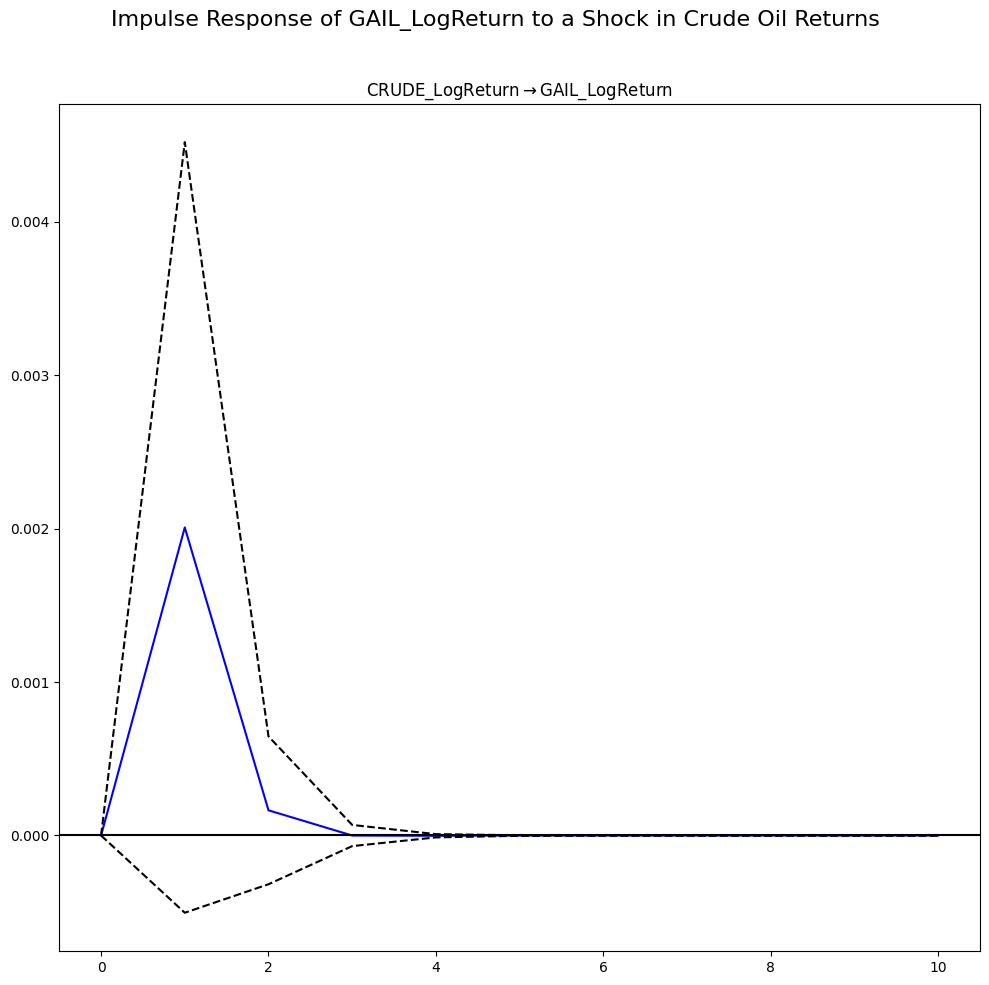

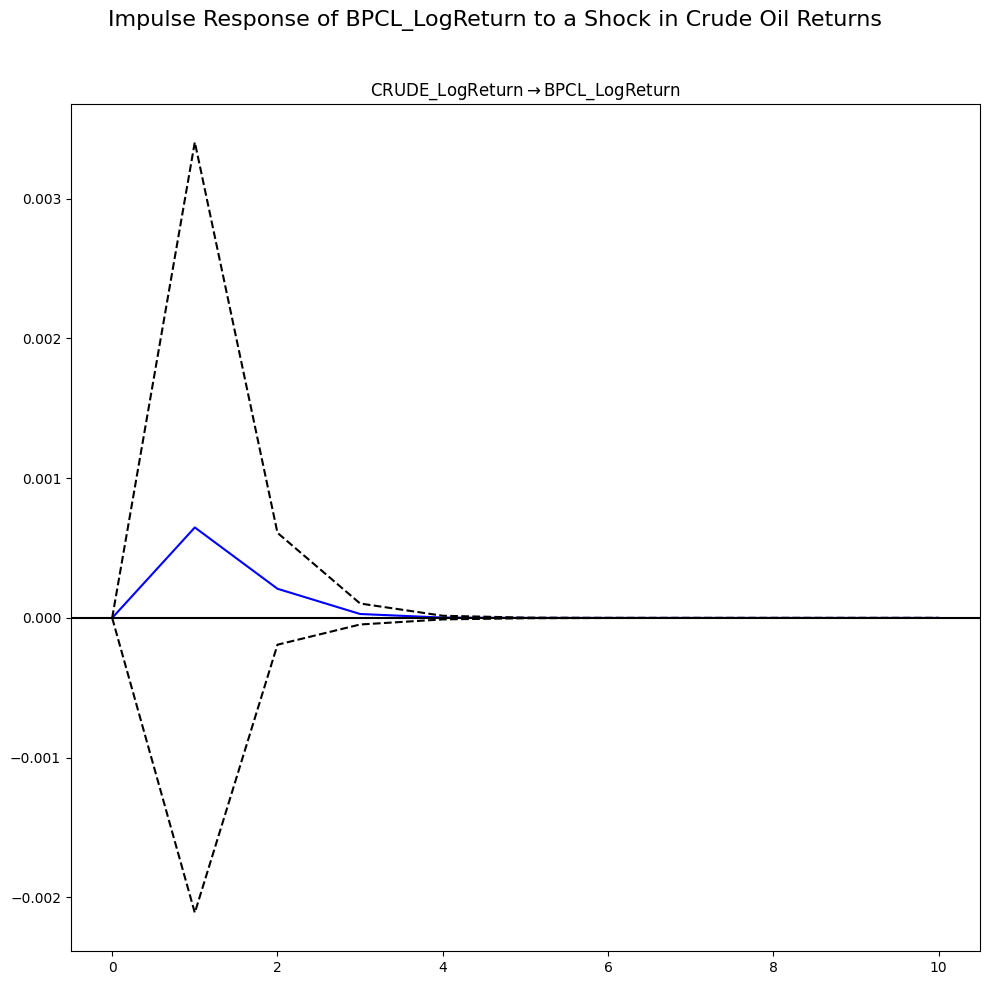

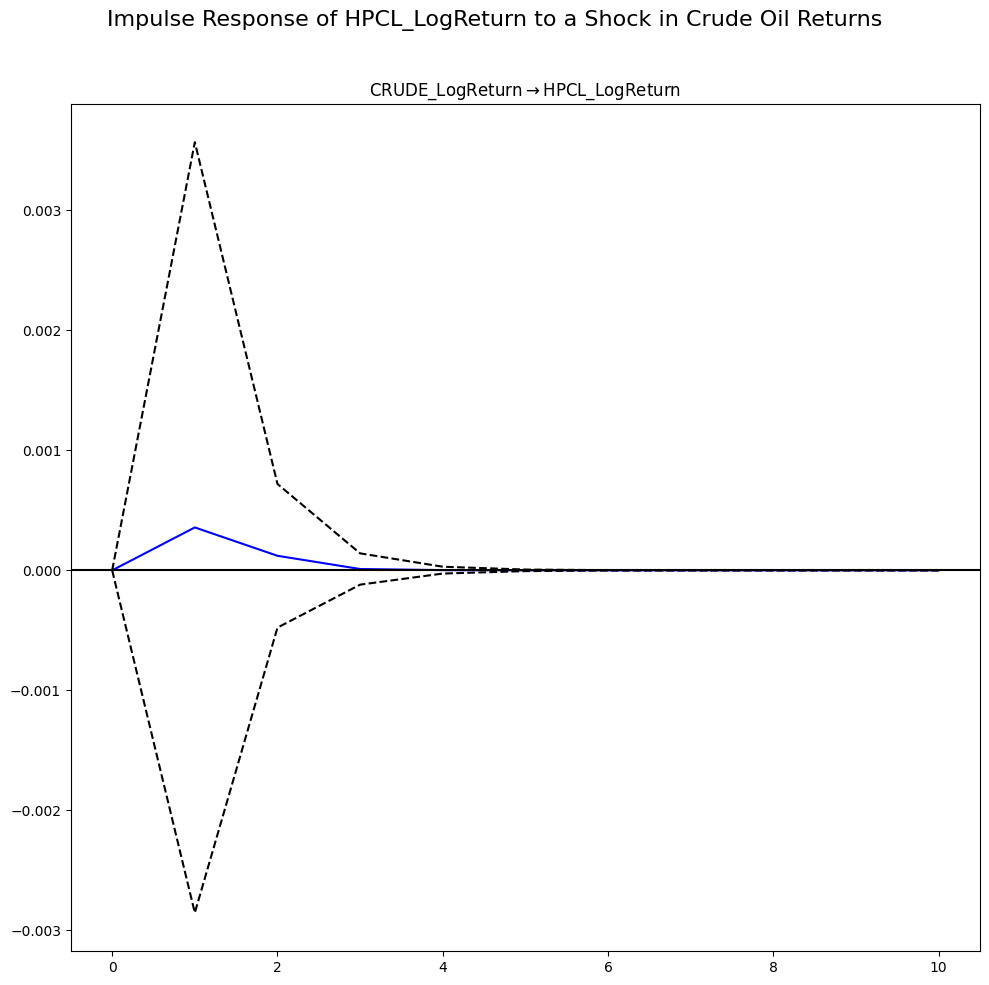

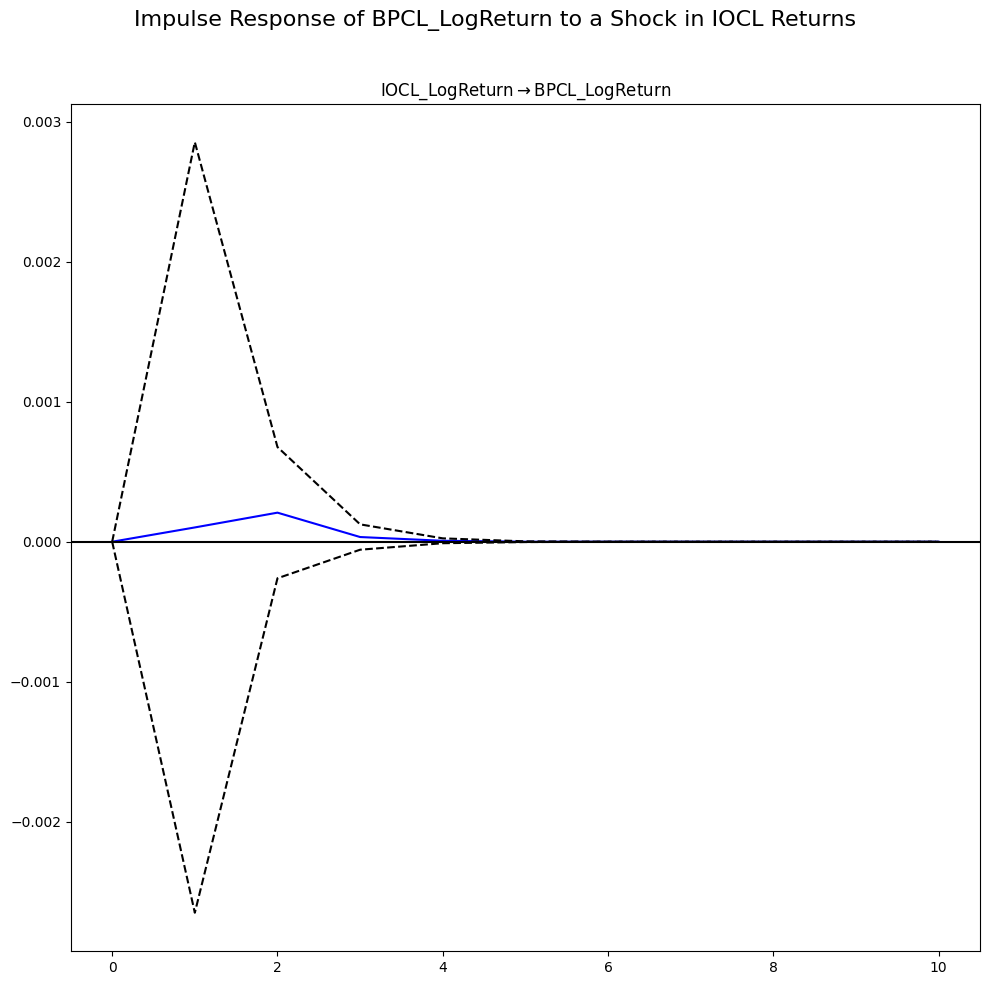

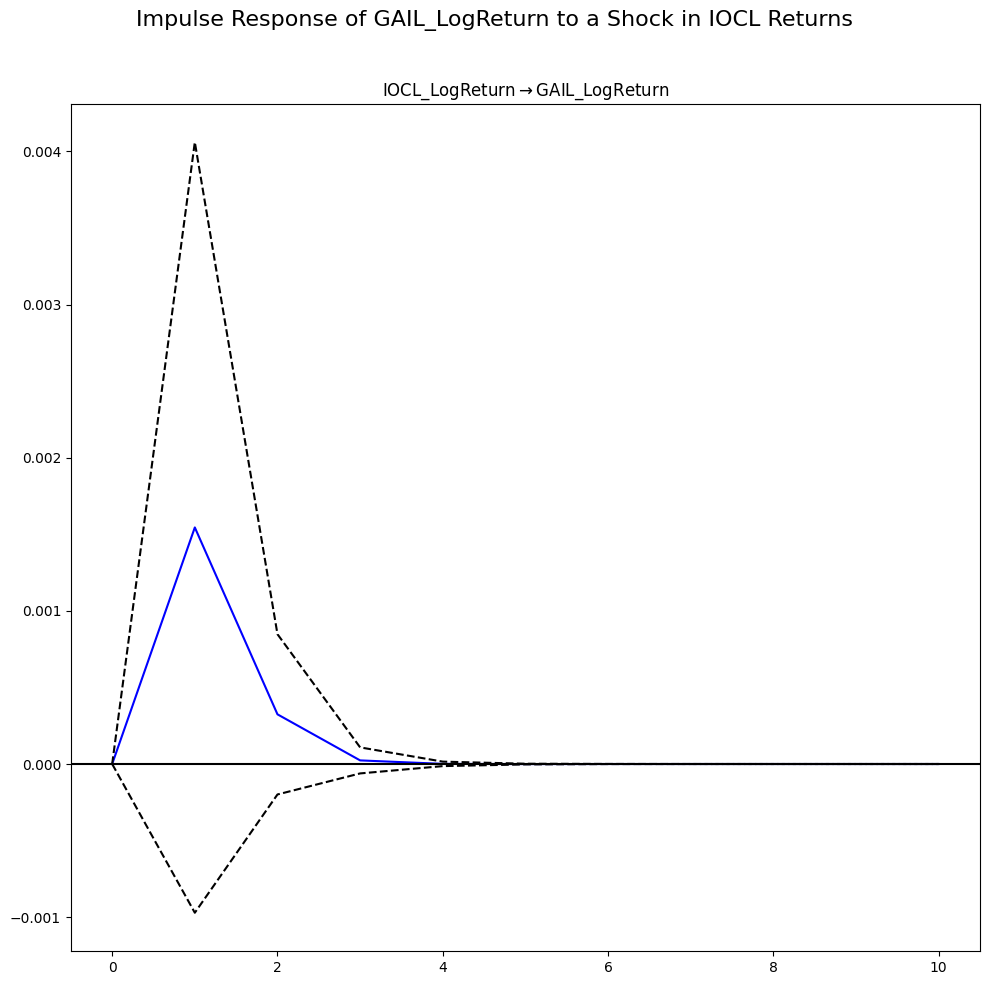

\n--- Calculating Forecast Error Variance Decomposition ---
FEVD available periods: 5. Using period 5.

FEVD Results at 5-day horizon (Contribution to forecast error variance):
                 HPCL_LogReturn  BPCL_LogReturn  GAIL_LogReturn  \
HPCL_LogReturn         0.015249        0.015622        0.015716   
BPCL_LogReturn         0.000137        0.000989        0.000989   
GAIL_LogReturn         0.002405        0.002441        0.002441   
IOCL_LogReturn         0.000079        0.000578        0.000582   
CRUDE_LogReturn        0.982129        0.980369        0.980272   

                 IOCL_LogReturn  CRUDE_LogReturn  
HPCL_LogReturn         0.015718         0.015718  
BPCL_LogReturn         0.000990         0.000990  
GAIL_LogReturn         0.002441         0.002441  
IOCL_LogReturn         0.000582         0.000582  
CRUDE_LogReturn        0.980270         0.980270  


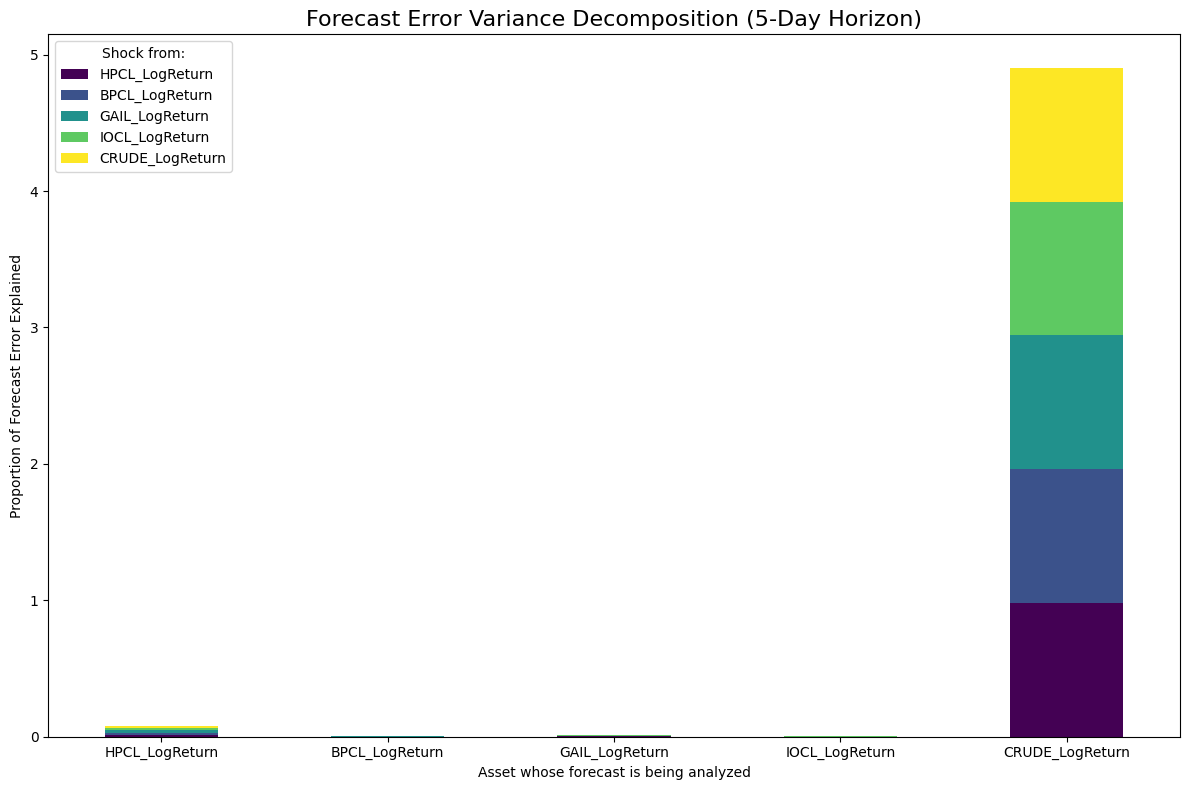

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# --- Prerequisite: Ensure log return columns exist in merged_df ---
log_return_cols = ['HPCL_LogReturn', 'BPCL_LogReturn', 'GAIL_LogReturn', 'IOCL_LogReturn', 'CRUDE_LogReturn']
close_cols = ['HPCL_Close', 'BPCL_Close', 'GAIL_Close', 'IOCL_Close', 'CRUDE_Close']

# Compute log returns if not already present
for asset, close_col, logret_col in zip(['HPCL', 'BPCL', 'GAIL', 'IOCL', 'CRUDE'], close_cols, log_return_cols):
    if logret_col not in merged_df.columns:
        merged_df[logret_col] = (
            pd.Series(np.log(merged_df[close_col] / merged_df[close_col].shift(1)))
            if close_col in merged_df.columns else pd.NA
        )

var_data = merged_df[log_return_cols].dropna()

# --- VISUAL 1: Time Series Plot of Log Returns ---
print("\\n--- Generating Time Series Plot of Log Returns ---")
var_data.plot(figsize=(15, 8), subplots=True, layout=(3, 2), legend=True)
plt.suptitle('Daily Log Returns (2016-2024)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('log_returns_timeseries.png')
plt.show()

# --- ANALYSIS: Fit the VAR(1) Model Again ---
model = VAR(var_data)
# The optimal lag was 1 from your previous analysis
results = model.fit(1)

# --- ANALYSIS 2: Impulse Response Functions (IRF) ---
print("\\n--- Calculating Impulse Response Functions ---")
irf = results.irf(periods=10) # Analyzing the response over 10 days

# --- VISUAL 2: Plotting Key IRFs ---
# Plot the response of GAIL, BPCL, and HPCL to a shock in CRUDE
for resp in ['GAIL_LogReturn', 'BPCL_LogReturn', 'HPCL_LogReturn']:
    if resp in var_data.columns:
        irf.plot(impulse='CRUDE_LogReturn', response=resp, orth=True)
        plt.suptitle(f'Impulse Response of {resp} to a Shock in Crude Oil Returns', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f'irf_crude_shock_{resp}.png')
        plt.show()

# Plot the response of BPCL and GAIL to a shock in IOCL
for resp in ['BPCL_LogReturn', 'GAIL_LogReturn']:
    if resp in var_data.columns:
        irf.plot(impulse='IOCL_LogReturn', response=resp, orth=True)
        plt.suptitle(f'Impulse Response of {resp} to a Shock in IOCL Returns', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f'irf_iocl_shock_{resp}.png')
        plt.show()


# --- ANALYSIS 3: Forecast Error Variance Decomposition (FEVD) ---
print("\\n--- Calculating Forecast Error Variance Decomposition ---")
fevd = results.fevd(10) # Analyzing over a 10-day horizon

# --- VISUAL 3: Plotting FEVD Results ---
# Use the last available period if fewer than 10 periods are available
available_periods = fevd.decomp.shape[0]
target_period = min(10, available_periods)  # 10th day or last available
fevd_idx = target_period - 1  # zero-based index

print(f"FEVD available periods: {available_periods}. Using period {fevd_idx + 1}.")

# Transpose so that index=variable explained, columns=shock source
fevd_period = fevd.decomp[fevd_idx].T  # shape: (n_variables, n_periods)
# Only use the first n_variables columns for DataFrame construction
n_vars = len(var_data.columns)
fevd_df = pd.DataFrame(
    fevd_period[:, :n_vars],
    index=var_data.columns,
    columns=var_data.columns
)

print(f"\nFEVD Results at {fevd_idx + 1}-day horizon (Contribution to forecast error variance):")
print(fevd_df)

# Plotting as a stacked bar chart
fevd_df.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='viridis')
plt.title(f'Forecast Error Variance Decomposition ({fevd_idx + 1}-Day Horizon)', fontsize=16)
plt.ylabel('Proportion of Forecast Error Explained')
plt.xlabel('Asset whose forecast is being analyzed')
plt.xticks(rotation=0)
plt.legend(title='Shock from:')
plt.tight_layout()
plt.savefig('fevd_barchart.png')
plt.show()